In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import sys
sys.path.insert(0,'/content/drive/My Drive/Colab_Notebooks/RecSys')

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms as T

from model.autoencoders import ConvVAE, LinearVAE, loss_vae

In [4]:
!nvidia-smi

Sat Jul 23 20:06:40 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   60C    P8    10W /  70W |      3MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [5]:
paths_pairs_bot = pd.read_csv('/content/drive/MyDrive/Colab_Notebooks/RecSys/arrays/paths_pairs_bot.csv', index_col=0)
paths_pairs_shoes = pd.read_csv('/content/drive/MyDrive/Colab_Notebooks/RecSys/arrays/paths_pairs_shoes.csv', index_col=0)

In [6]:
#top_photos = np.load('/content/drive/MyDrive/Colab_Notebooks/RecSys/arrays/top_photos.npy', allow_pickle=True)
#bot_photos = np.load('/content/drive/MyDrive/Colab_Notebooks/RecSys/arrays/bot_photos.npy', allow_pickle=True) #mmap_mode='c'
bot_photos_shoes = np.load('/content/drive/MyDrive/Colab_Notebooks/RecSys/arrays/bot_photos_shoes.npy', allow_pickle=True)
shoes_photos = np.load('/content/drive/MyDrive/Colab_Notebooks/RecSys/arrays/shoes_photos.npy', allow_pickle=True)

In [7]:
#train_photos_top, val_photos_top = train_test_split(top_photos, train_size=0.9, shuffle=False)
#train_photos_bot, val_photos_bot = train_test_split(bot_photos, train_size=0.9, shuffle=False)
train_photos_bot_shoes, val_photos_bot_shoes = train_test_split(bot_photos_shoes, train_size=0.9, shuffle=False)
train_photos_shoes, val_photos_shoes = train_test_split(shoes_photos, train_size=0.9, shuffle=False)

bs = 32

#train_loader_top = torch.utils.data.DataLoader(train_photos_top, batch_size=bs)
#val_loader_top = torch.utils.data.DataLoader(val_photos_top, batch_size=bs)

#train_loader_bot = torch.utils.data.DataLoader(train_photos_bot, batch_size=bs)
#val_loader_bot = torch.utils.data.DataLoader(val_photos_bot, batch_size=bs)

train_loader_bot_shoes = torch.utils.data.DataLoader(train_photos_bot_shoes, batch_size=bs)
val_loader_bot_shoes = torch.utils.data.DataLoader(val_photos_bot_shoes, batch_size=bs)

train_loader_shoes = torch.utils.data.DataLoader(train_photos_shoes, batch_size=bs)
val_loader_shoes = torch.utils.data.DataLoader(val_photos_shoes, batch_size=bs)

In [8]:
torch.cuda.empty_cache()

In [9]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

In [10]:
vae_bot = ConvVAE().to(device)
optimizer = torch.optim.AdamW(vae_bot.parameters(), lr=3e-4) 

In [11]:
vae_bot

ConvVAE(
  (encoder): Sequential(
    (0): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.1, inplace=True)
    (3): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.1, inplace=True)
    (6): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2))
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.1, inplace=True)
    (9): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2))
    (10): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): LeakyReLU(negative_slope=0.1, inplace=True)
    (12): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2))
    (13): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   

In [12]:
# code for checking correctness of output image after convolutions
for idx, images in enumerate(train_loader_top):
    images = images.permute(0,3,1,2).to(device, dtype=torch.float)
    recon_images, mu, logvar = vae_bot(images)
    print(images.shape)
    print(recon_images.shape)
    break

torch.Size([32, 3, 128, 128])
torch.Size([32, 3, 128, 128])


In [13]:
# training model for generating bot
epochs = 30
train_losses = []

for epoch in tqdm(range(epochs)):
    vae_bot.train()
    train_losses_per_epoch = []
    for images, images_bot in zip(train_loader_top, train_loader_bot):
        optimizer.zero_grad()
        images = images.to(device, dtype=torch.float)
        images = images.permute(0,3,1,2).to(device, dtype=torch.float)
        images_bot = images_bot.permute(0,3,1,2).to(device, dtype=torch.float)
        recon_images, mu, logvar = vae_bot(images)
        loss = loss_vae(images_bot, mu, logvar, recon_images)
        
        loss.backward()
        optimizer.step()

        train_losses_per_epoch.append(loss.item())
        
    print(f"Epoch: {epoch+1}/{epochs} Loss: {np.mean(train_losses_per_epoch)}")
    train_losses.append(np.mean(train_losses_per_epoch))  

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch: 1/30 Loss: 659807.9128125
Epoch: 2/30 Loss: 381746.034375
Epoch: 3/30 Loss: 334081.866875
Epoch: 4/30 Loss: 319059.855625
Epoch: 5/30 Loss: 311752.5728125
Epoch: 6/30 Loss: 306413.5428125
Epoch: 7/30 Loss: 302865.6303125
Epoch: 8/30 Loss: 298080.46546875
Epoch: 9/30 Loss: 295035.499375
Epoch: 10/30 Loss: 292215.52953125
Epoch: 11/30 Loss: 289790.66359375
Epoch: 12/30 Loss: 286805.979375
Epoch: 13/30 Loss: 283696.83734375
Epoch: 14/30 Loss: 280417.82953125
Epoch: 15/30 Loss: 278508.004375
Epoch: 16/30 Loss: 276394.773125
Epoch: 17/30 Loss: 274351.6675
Epoch: 18/30 Loss: 272249.26453125
Epoch: 19/30 Loss: 271113.770625
Epoch: 20/30 Loss: 270208.81078125
Epoch: 21/30 Loss: 268966.09078125
Epoch: 22/30 Loss: 267597.66390625
Epoch: 23/30 Loss: 265641.0703125
Epoch: 24/30 Loss: 264233.271875
Epoch: 25/30 Loss: 263031.11765625
Epoch: 26/30 Loss: 261621.37984375
Epoch: 27/30 Loss: 260718.70734375
Epoch: 28/30 Loss: 260108.7003125
Epoch: 29/30 Loss: 258631.28140625
Epoch: 30/30 Loss: 257

In [14]:
vae_bot.eval()
with torch.no_grad():
    for batch, batch_bot in zip(val_loader_top, val_loader_bot):
        batch = batch.permute(0,3,1,2).to(device, dtype=torch.float)
        reconstruction, mu, logsigma = vae_bot(batch.to(device))
        #reconstruction = reconstruction.view(-1, dimx, dimy, 3)
        result = reconstruction.cpu().detach().numpy()
        ground_truth = batch_bot.cpu().numpy()
        orig = batch.cpu().numpy()
        break

Get embedding of all bot images to find the most similar.

In [15]:
embeddings_bot = torch.Tensor([]).to(device, dtype=torch.float)
for images_bot in train_loader_bot:
    images_bot = images_bot.to(device, dtype=torch.float)
    images_bot = images_bot.permute(0,3,1,2).to(device, dtype=torch.float)
    embeddings_bot = torch.cat((embeddings_bot, vae_bot.encode(images_bot)[0]), 0) 

for images_bot in val_loader_bot:
    images_bot = images_bot.to(device, dtype=torch.float)
    images_bot = images_bot.permute(0,3,1,2).to(device, dtype=torch.float)
    embeddings_bot = torch.cat((embeddings_bot, vae_bot.encode(images_bot)[0]), 0) 



In [18]:
bot_photos.shape

(3548,)

In [19]:
embeddings_bot.shape

torch.Size([3548, 128])

In [16]:
def find_k_neighbours(k, data, test):
    dist = torch.norm(data - test, dim=1, p=None)
    knn = dist.topk(k, largest=False)

    return knn.indices

In [22]:
result_tensor = torch.Tensor(result).to(device, dtype=torch.float)
embed = vae_bot.encode(result_tensor)[0]
embed

tensor([[ 0.5674,  0.9054,  1.3737,  ..., -0.2343,  0.4393, -0.6806],
        [ 0.7150,  0.4406,  0.9091,  ..., -0.2651,  1.0206,  0.1483],
        [ 1.0983, -1.2219,  1.1660,  ..., -0.9154,  0.7169,  0.7118],
        ...,
        [ 0.1077, -1.9220,  1.6664,  ...,  0.4948,  0.5221,  0.9766],
        [ 0.6206, -1.4068, -0.3413,  ..., -0.8601,  0.3760,  0.5884],
        [ 0.8824,  0.3079,  0.7372,  ..., -0.5578, -0.0267,  1.5756]],
       device='cuda:0', grad_fn=<AddBackward0>)

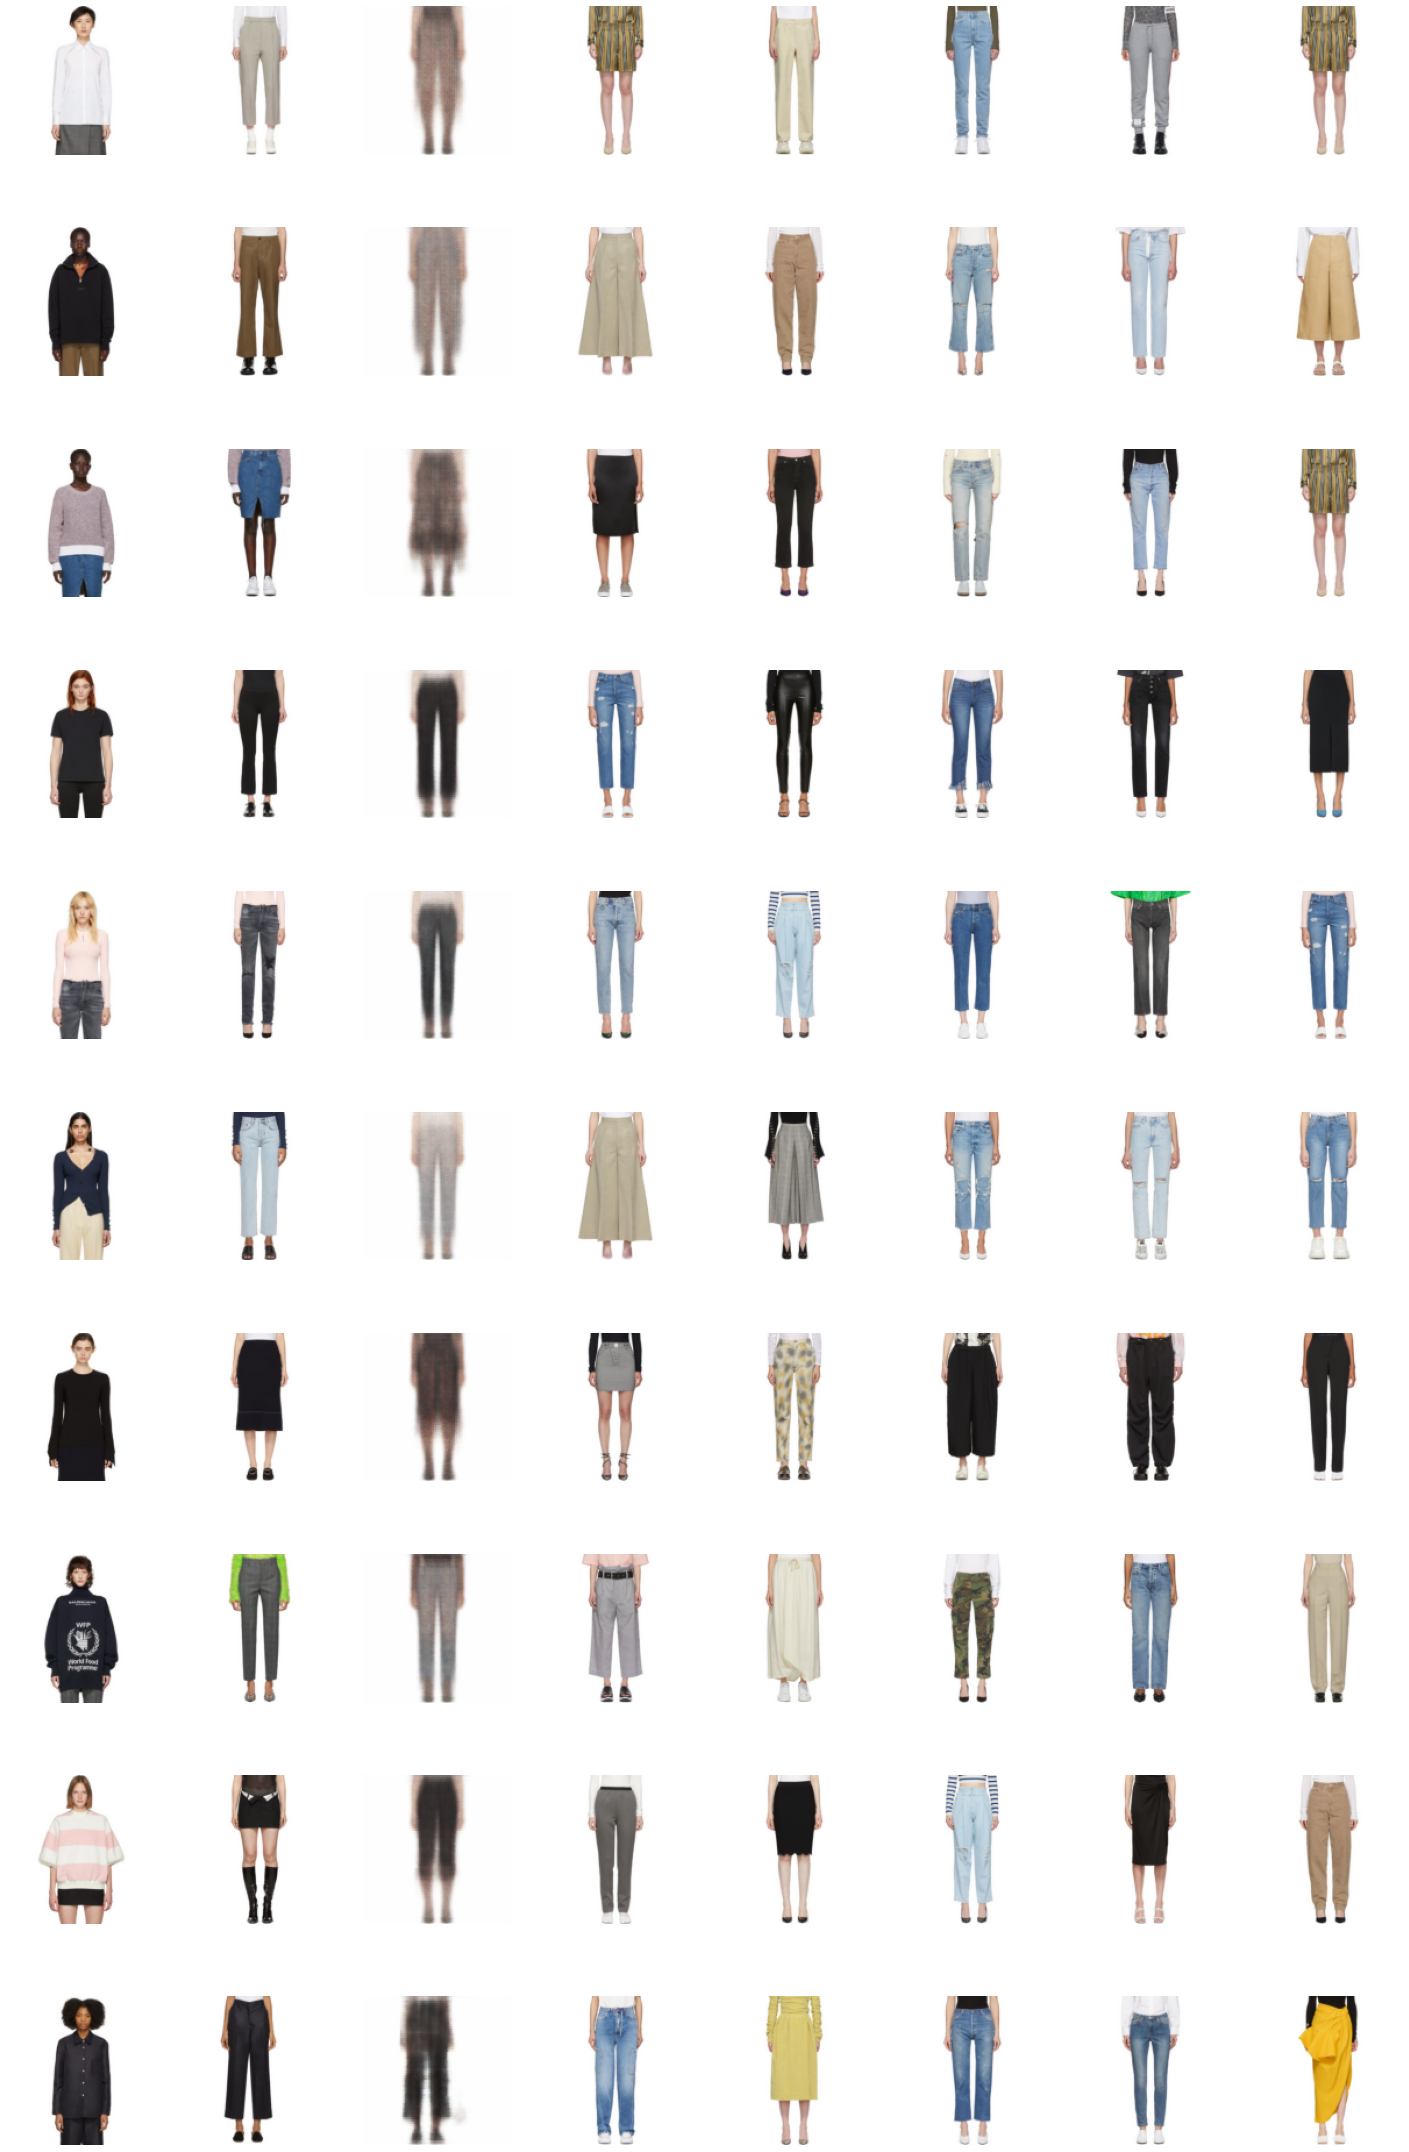

In [24]:
plt.figure(figsize=(25, 40))
k = 10
num_items = 8
for i, (org, gt, res, emb) in enumerate(zip(orig[:k], ground_truth[:k], result[:k], embed[:k])):
    #gt = np.moveaxis(gt, 0, -1)
    res = np.moveaxis(res, 0, -1)
    org = np.moveaxis(org, 0, -1)

    plt.subplot(10, num_items, num_items*i+1)
    plt.axis('off')
    plt.imshow(org)
    plt.subplot(10, num_items, num_items*i+2)
    plt.axis('off')
    plt.imshow(gt)
    plt.subplot(10, num_items, num_items*i+3)
    plt.imshow(res)
    plt.axis('off')

    # find 5 most similar images and show them
    indices = find_k_neighbours(5, embeddings_bot, emb)
    
    plt.subplot(10, num_items, num_items*i+4)
    plt.axis('off')
    plt.imshow(bot_photos[indices[0]])

    plt.subplot(10, num_items, num_items*i+5)
    plt.axis('off')
    plt.imshow(bot_photos[indices[1]])

    plt.subplot(10, num_items, num_items*i+6)
    plt.axis('off')
    plt.imshow(bot_photos[indices[2]])

    plt.subplot(10, num_items, num_items*i+7)
    plt.axis('off')
    plt.imshow(bot_photos[indices[3]])

    plt.subplot(10, num_items, num_items*i+8)
    plt.axis('off')
    plt.imshow(bot_photos[indices[4]])


In [10]:
vae_shoes = ConvVAE().to(device)
optimizer = torch.optim.AdamW(vae_shoes.parameters(), lr=3e-4) 

In [11]:
# training model for generating shoes
epochs = 30
train_losses = []

for epoch in tqdm(range(epochs)):
    vae_shoes.train()
    train_losses_per_epoch = []
    
    for images, images_bot in zip(train_loader_bot_shoes, train_loader_shoes):
        optimizer.zero_grad()
        images = images.to(device, dtype=torch.float)
        images = images.permute(0,3,1,2).to(device, dtype=torch.float)
        images_bot = images_bot.permute(0,3,1,2).to(device, dtype=torch.float)
        recon_images, mu, logvar = vae_shoes(images)
        #recon_images = recon_images.view(-1, dimx, dimy, 3)
        loss = loss_vae(images_bot, mu, logvar, recon_images)
        
        loss.backward()
        optimizer.step()

        train_losses_per_epoch.append(loss.item())
        
    print(f"Epoch: {epoch+1}/{epochs} Loss: {np.mean(train_losses_per_epoch)}")
    train_losses.append(np.mean(train_losses_per_epoch))

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch: 1/30 Loss: 659906.5892333984
Epoch: 2/30 Loss: 468625.65022786456
Epoch: 3/30 Loss: 454953.7453613281
Epoch: 4/30 Loss: 445891.1798909505
Epoch: 5/30 Loss: 438744.4800211589
Epoch: 6/30 Loss: 432122.5313720703
Epoch: 7/30 Loss: 425730.2762858073
Epoch: 8/30 Loss: 418557.8280029297
Epoch: 9/30 Loss: 410981.1416422526
Epoch: 10/30 Loss: 405081.95100911456
Epoch: 11/30 Loss: 400166.48128255206
Epoch: 12/30 Loss: 395173.05997721356
Epoch: 13/30 Loss: 388545.08752441406
Epoch: 14/30 Loss: 383976.8465983073
Epoch: 15/30 Loss: 378780.64534505206
Epoch: 16/30 Loss: 374048.1489664714
Epoch: 17/30 Loss: 367415.3350626628
Epoch: 18/30 Loss: 364521.9947916667
Epoch: 19/30 Loss: 361059.7429402669
Epoch: 20/30 Loss: 358102.89186604816
Epoch: 21/30 Loss: 353304.69394938153
Epoch: 22/30 Loss: 350520.58577473956
Epoch: 23/30 Loss: 346486.2079671224
Epoch: 24/30 Loss: 343031.5211385091
Epoch: 25/30 Loss: 339679.58284505206
Epoch: 26/30 Loss: 336477.33575439453
Epoch: 27/30 Loss: 335301.9730224609

In [12]:
vae_shoes.eval()
with torch.no_grad():
    for batch, batch_bot in zip(val_loader_bot_shoes, val_loader_shoes):
        batch = batch.permute(0,3,1,2).to(device, dtype=torch.float)
        reconstruction, mu, logsigma = vae_shoes(batch.to(device))
        #reconstruction = reconstruction.view(-1, dimx, dimy, 3)
        result = reconstruction.cpu().detach().numpy()
        ground_truth = batch_bot.cpu().numpy()
        orig = batch.cpu().numpy()
        break

In [13]:
torch.cuda.empty_cache()

In [14]:
embeddings_shoes = torch.Tensor([]).to(device, dtype=torch.float)
for images_shoes in train_loader_shoes:
    images_shoes = images_shoes.to(device, dtype=torch.float)
    images_shoes = images_shoes.permute(0,3,1,2).to(device, dtype=torch.float)
    embeddings_shoes = torch.cat((embeddings_shoes, vae_shoes.encode(images_shoes)[0]), 0) 

for images_shoes in val_loader_shoes:
    images_shoes = images_shoes.to(device, dtype=torch.float)
    images_shoes = images_shoes.permute(0,3,1,2).to(device, dtype=torch.float)
    embeddings_shoes = torch.cat((embeddings_shoes, vae_shoes.encode(images_shoes)[0]), 0) 

In [15]:
result_tensor = torch.Tensor(result).to(device, dtype=torch.float)
embed = vae_shoes.encode(result_tensor)[0]
embed

tensor([[ 0.6243, -0.2396, -1.3923,  ...,  0.5999, -0.6232, -1.2905],
        [ 0.5387,  0.3735,  0.3678,  ..., -1.0975,  0.2319, -0.0250],
        [-0.0730,  0.5194,  0.0656,  ..., -0.8107,  0.0557, -0.1902],
        ...,
        [-0.0110,  0.3799, -1.7258,  ..., -0.4143, -0.0949, -0.2938],
        [ 0.5299,  0.2728,  1.2060,  ..., -0.0511, -0.0044,  1.1543],
        [-0.5298,  0.8933,  1.2660,  ..., -1.1416, -0.0244,  1.2296]],
       device='cuda:0', grad_fn=<AddBackward0>)

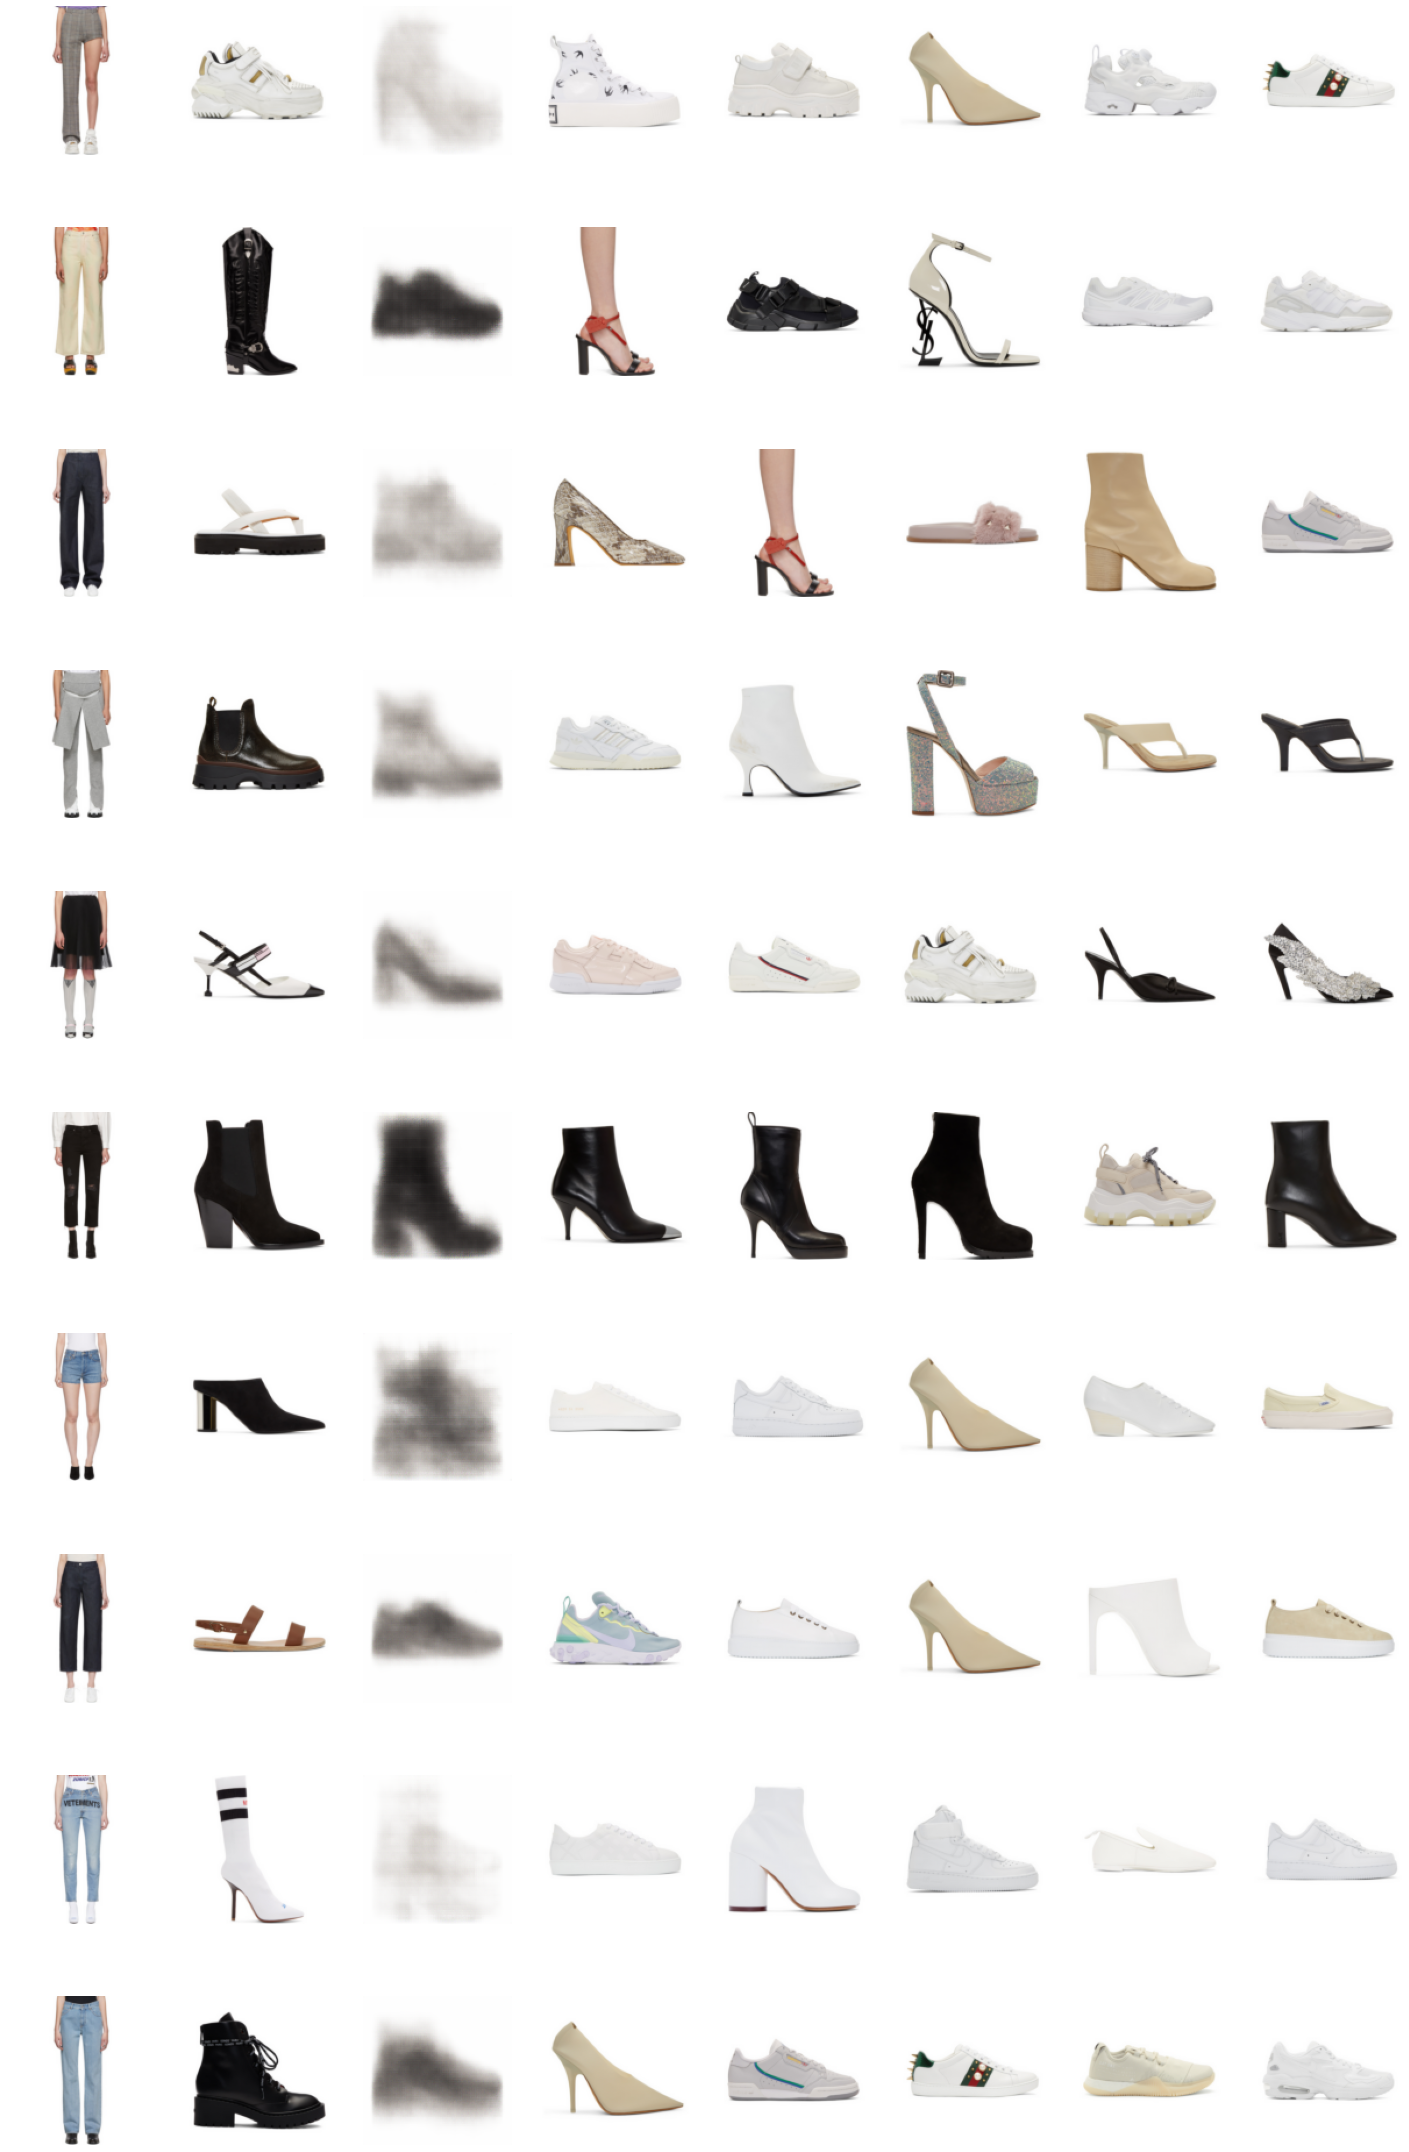

In [17]:
plt.figure(figsize=(25, 40))
k = 10
num_items = 8
for i, (org, gt, res, emb) in enumerate(zip(orig[:k], ground_truth[:k], result[:k], embed[:k])):
    #gt = np.moveaxis(gt, 0, -1)
    res = np.moveaxis(res, 0, -1)
    org = np.moveaxis(org, 0, -1)

    plt.subplot(10, num_items, num_items*i+1)
    plt.axis('off')
    plt.imshow(org)
    plt.subplot(10, num_items, num_items*i+2)
    plt.axis('off')
    plt.imshow(gt)
    plt.subplot(10, num_items, num_items*i+3)
    plt.imshow(res)
    plt.axis('off')

    indices = find_k_neighbours(5, embeddings_shoes, emb)
    
    plt.subplot(10, num_items, num_items*i+4)
    plt.axis('off')
    plt.imshow(shoes_photos[indices[0]])

    plt.subplot(10, num_items, num_items*i+5)
    plt.axis('off')
    plt.imshow(shoes_photos[indices[1]])

    plt.subplot(10, num_items, num_items*i+6)
    plt.axis('off')
    plt.imshow(shoes_photos[indices[2]])

    plt.subplot(10, num_items, num_items*i+7)
    plt.axis('off')
    plt.imshow(shoes_photos[indices[3]])

    plt.subplot(10, num_items, num_items*i+8)
    plt.axis('off')
    plt.imshow(shoes_photos[indices[4]])

In [ ]:
"""
train_transforms = T.Compose([
                              T.Resize(256),
                              T.ToTensor(),
                              T.Normalize(        
                                  mean=[0.485, 0.456, 0.406],
                                  std=[0.229, 0.224, 0.225]
                                  )
                              
])

test_transforms = T.Compose([
                             T.Resize(256),
                             T.ToTensor(),
                             T.Normalize(        
                                  mean=[0.485, 0.456, 0.406],
                                  std=[0.229, 0.224, 0.225]
                                  )
])
"""